In [18]:
from tensorflow.keras.datasets.cifar10 import load_data
from matplotlib import pyplot
import tensorflow as tf 
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten, Conv2DTranspose, Dense, Dropout, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import randn
from numpy.random import randint

In [4]:

(train_X,train_y), (test_X, test_y) = load_data() 

print('Train', train_X.shape, train_y.shape)
print('Train', test_X.shape, train_y.shape)

Train (50000, 32, 32, 3) (50000, 1)
Train (10000, 32, 32, 3) (50000, 1)


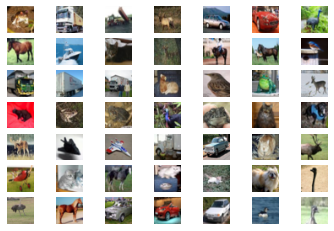

In [5]:
for i in range(49):
    pyplot.subplot(7,7,1+i)
    pyplot.axis('off')
    pyplot.imshow(train_X[i])
pyplot.show()

In [6]:
def discriminator(in_shape=(32,32,3)):
    model = Sequential()
    #normal
    model.add(Conv2D(64,(3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    #downsample
    model.add(Conv2D(128,(3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    #downsample
    model.add(Conv2D(128,(3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    #downsample
    model.add(Conv2D(256,(3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    #classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    #compile
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# model = discriminator()
# model.summary()
# plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [7]:
#load and prepare cifar10 training images
def load_real_samples():
    #load cifar10 samples
    (trainX,_),(_,_) = load_data()
    X= trainX.astype('float32')    
    X = (X-127.5)/127.5 
    return X

In [8]:
#real sample selection
def generate_real_samples(dataset, n_samples):
    #choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    #retrieve selected images
    X = dataset[ix]
    #generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y 

In [9]:
#generate n fake samples with class labels to train discriminator beforehand
def generate_fake_samples(n_samples):
    #generate uniform random numbers in [0,1]
    X = rand(32*32*3*n_samples)
    #update to have the range[-1,1]
    X = -1 + X*2
    # reshape into a batch of color images
    X = X.reshape((n_samples, 32, 32, 3))
    # generate 'fake' class labels (0)
    y = zeros((n_samples,1))
    return X, y



In [10]:
#train the discriminator
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
    half_batch = int(n_batch/2)
    #manually enumerate epochs 
    for i in range(n_iter):
        #get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        #generate fake examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        #update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        #summarize
        print('>%d real=%.0f%% fake=%.0f%%' %(i+1, real_acc*100, fake_acc*100))



In [11]:
model = discriminator()
dataset = load_real_samples()
train_discriminator(model, dataset)

&gt;1 real=27% fake=2%
&gt;2 real=92% fake=6%
&gt;3 real=89% fake=30%
&gt;4 real=97% fake=72%
&gt;5 real=88% fake=95%
&gt;6 real=89% fake=100%
&gt;7 real=91% fake=100%
&gt;8 real=84% fake=100%
&gt;9 real=86% fake=100%
&gt;10 real=86% fake=100%
&gt;11 real=92% fake=100%
&gt;12 real=91% fake=100%
&gt;13 real=95% fake=100%
&gt;14 real=100% fake=100%
&gt;15 real=100% fake=100%
&gt;16 real=95% fake=100%
&gt;17 real=98% fake=100%
&gt;18 real=100% fake=100%
&gt;19 real=98% fake=100%
&gt;20 real=100% fake=100%


In [14]:
def generator(latent_dim):
    model = Sequential()
    #foundation for 4x4
    n_nodes = 256*4*4   #giving the space to create different feature maps parallely
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4,4,256)))

    #upsample to 8x8
    model.add(Conv2DTranspose(128,(4,4), strides=(2,2), padding='same')) #kernel size should be a factor of stride to avoid checkboarding
    model.add(LeakyReLU(alpha=0.2))

    #upsample to 16x16
    model.add(Conv2DTranspose(128,(4,4), strides=(2,2), padding='same')) #kernel size should be a factor of stride to avoid checkboarding
    model.add(LeakyReLU(alpha=0.2))

    #upsample to 32x32
    model.add(Conv2DTranspose(128,(4,4), strides=(2,2), padding='same')) #kernel size should be a factor of stride to avoid checkboarding
    model.add(LeakyReLU(alpha=0.2))

    #output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model





Model: &quot;sequential_2&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 

In [15]:
#generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    #generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    #reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


In [16]:
#use the generator to generate n fake examples, with class labels (made from generate_fake_samples)
def fake_sampler(g_model, latent_dim, n_samples):
    X_input = generate_latent_points(latent_dim, n_samples)
    #predict outputs
    X = g_model.predict(X_input)
    #create 'fake' class labels(0)
    y = zeros((n_samples, 1))
    return X,y


Model: &quot;sequential_4&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 16, 16, 

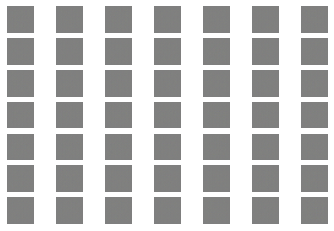

In [19]:
latent_dim = 100 #round number and widely used but not compulsory
model = generator(latent_dim)
model.summary()
n_samples = 49
X, _ = fake_sampler(model, latent_dim, n_samples)
#scale pixel values from [-1,1] to [0,1]
X = (X+1)/2.0
#plot 
for i in range(n_samples):
    #define subplot
    pyplot.subplot(7,7,1+i)
    #turn off the axis labels
    pyplot.axis('off')
    pyplot.imshow(X[i])

pyplot.show()

In [22]:
def gan(g_model, d_model):
    #make weights in the discriminator not trainable
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    #compile
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


In [23]:
latent_dim = 100
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = gan(g_model, d_model)
gan_model.summary()


Model: &quot;sequential_10&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (None, 32, 32, 3)         1466115   
_________________________________________________________________
sequential_8 (Sequential)    (None, 1)                 522497    
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


In [27]:
def train_gan(gan_model, latent_dim, n_epochs=200, n_batch=128):
    #manually enumerate epochs 
    for i in range(n_epochs):
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        #create inverted labels for the fake samples so that discriminator proving it fake will count as an error and in turn generators model weights only (discriminator weights are not trainable) will be updated to create better 'real' images
        y_gan = ones((n_batch, 1))
        #update the generator  via the discriminator's error
        gan_model.train_on_batch(X_gan, y_gan)

SyntaxError: non-default argument follows default argument (&lt;ipython-input-27-6b7b34b7f72a&gt;, line 1)